In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# suppress warning
import warnings
warnings.filterwarnings('ignore')
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import scipy
%matplotlib inline

In [322]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/australian_capital_retail.csv')

<AxesSubplot:>

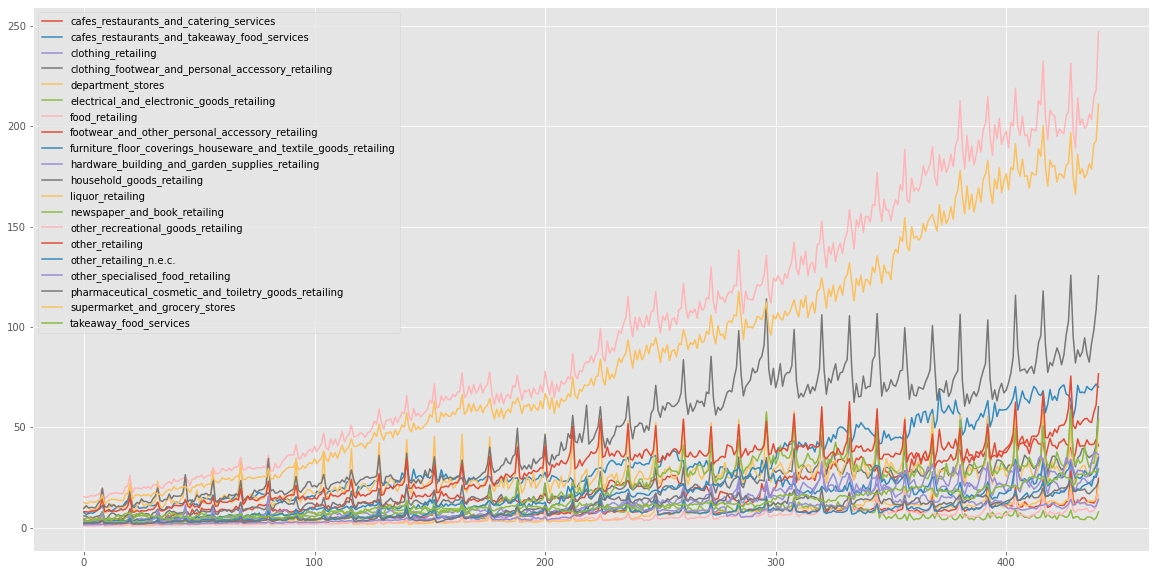

In [323]:
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')
df.plot()

#### Figure 1. 1. Visualize the data: General plot for all of the elements in the dataset. 

# Homework 1: Using ARIMA model to predict food_retail capital in Australia.

## Task 1. Sum up the yearly capital of food retailing and visualize the timeline.

In [324]:
# Converting the date column to its specified data type
df['month'] = pd.to_datetime(df.month)
# Creating three new columns for easy querying
df['YEAR'] = df.month.dt.year
df['MONTH'] = df.month.dt.month
df['DAY'] = df.month.dt.day
#df.head()

In [325]:
df_time =df.month = pd.to_datetime(df.month)
df.index=[df.month.dt.year,df.month.dt.month]
#df_time

In [326]:
df1= df[['YEAR','food_retailing']]
#df1

In [327]:
#using the groupby function to Sum up the yearly capital of food retailing
df2 = df1.groupby(['YEAR']).sum()
#df2

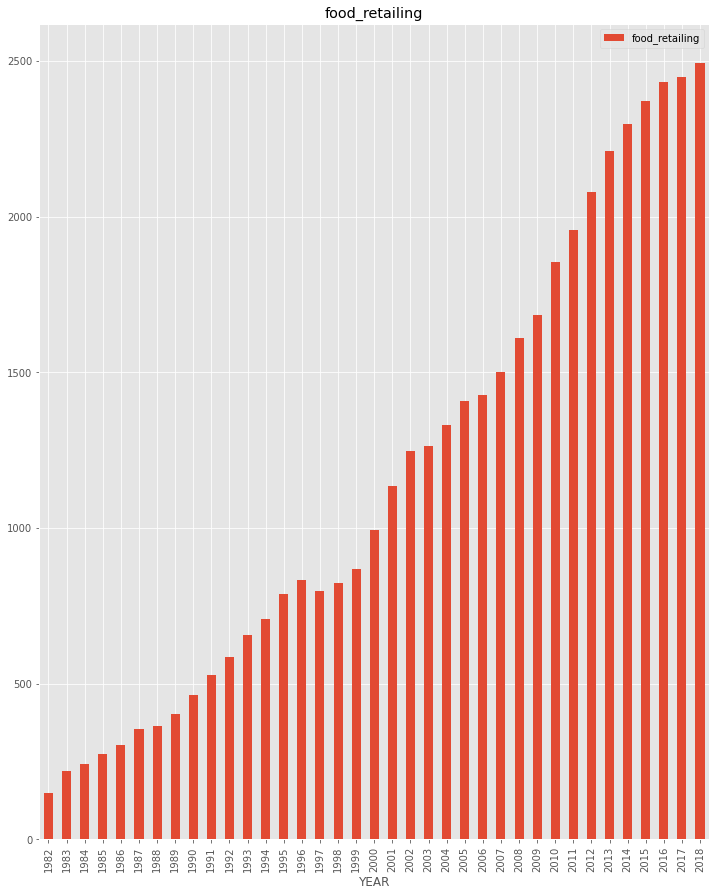

In [328]:
axs = df2.plot.bar(figsize=(12,15), subplots=True )

#### Figure 2. The sum of the Food_Retailing
Reflects an Increase in the Food Retailing demand over the course of the 37 years

## Task 2. Use the adfuller tool to determine if the time series is stationary or not, $\alpha=0.05$. If not, find a proper order of differencing (d) in the ARIMA model to reach the stationarity, and report adfuller test results after differencing.

In [329]:
from statsmodels.tsa.stattools import adfuller
series=df['food_retailing']
result = adfuller(series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 1.464494
p-value: 0.997388
Critical Values:
	1%: -3.446
	5%: -2.868
	10%: -2.570


In [330]:
#Adfuller tool to determin the ADF, p-value and the adf_test
adf_test = adfuller(df2['food_retailing'])
print(adf_test)
print ("ADF = " + str(adf_test[0]))
print ("p-value = " +str(adf_test[1]))

(2.5483085291590384, 0.9990637907499603, 7, 29, {'1%': -3.6790595944893187, '5%': -2.9678817237279103, '10%': -2.6231583472057074}, 272.525365949495)
ADF = 2.5483085291590384
p-value = 0.9990637907499603


### Stationarize the data:

In [331]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 10 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

#### test_stationarity function

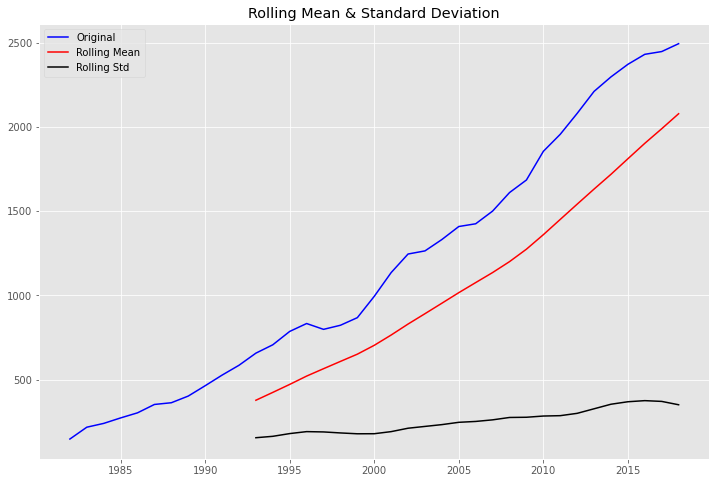

Results of Dickey-Fuller Test:
p-value = 0.9991. The series is likely non-stationary.
Test Statistic                  2.548309
p-value                         0.999064
#Lags Used                      7.000000
Number of Observations Used    29.000000
Critical Value (1%)            -3.679060
Critical Value (5%)            -2.967882
Critical Value (10%)           -2.623158
dtype: float64


In [332]:
test_stationarity(df2['food_retailing'])

Here our p-value is 0.9991.

In [333]:
#df_log= df2.food_retailing.apply(lambda x: np.log(x))  
#test_stationarity(df_log)

### Differencing (d) in the ARIMA model to reach the stationarity

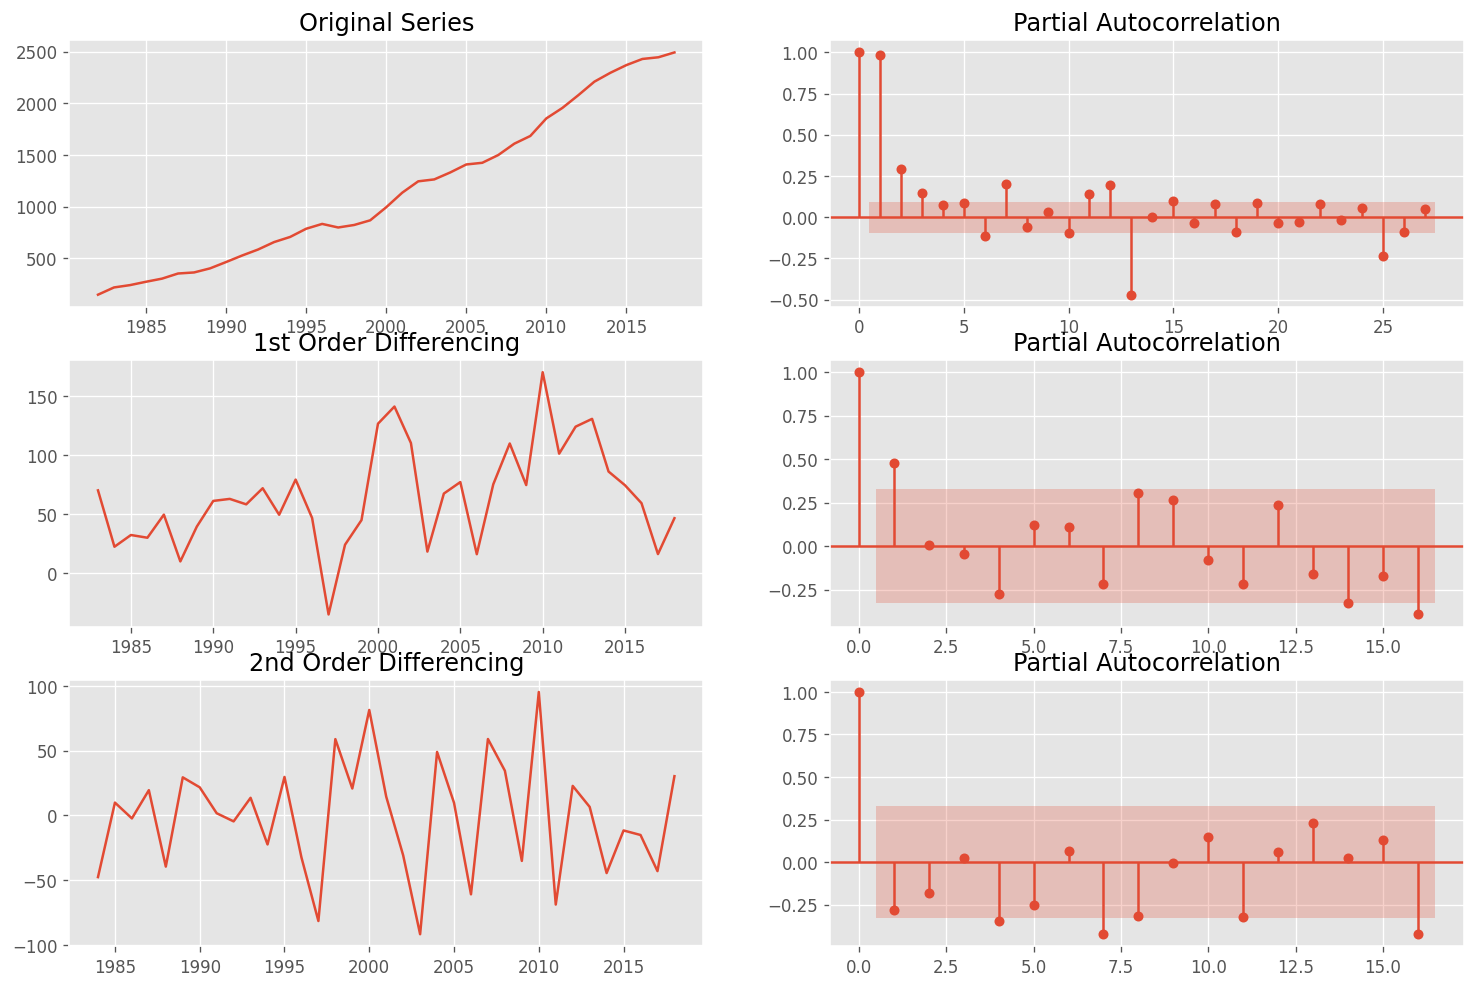

In [334]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(15,10), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(df2.food_retailing); axes[0, 0].set_title('Original Series')
plot_pacf(df.food_retailing, ax=axes[0, 1])
axes[0, 1].set_title('Partial Autocorrelation')

# 1st Differencing
axes[1, 0].plot(df2.food_retailing.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_pacf(df2.food_retailing.diff().dropna(), ax=axes[1, 1])
axes[1, 1].set_title('Partial Autocorrelation')

# 2nd Differencing
axes[2, 0].plot(df2.food_retailing.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_pacf(df2.food_retailing.diff().diff().dropna(), ax=axes[2, 1])
axes[2, 1].set_title('Partial Autocorrelation')
plt.show()

### First difference of the data

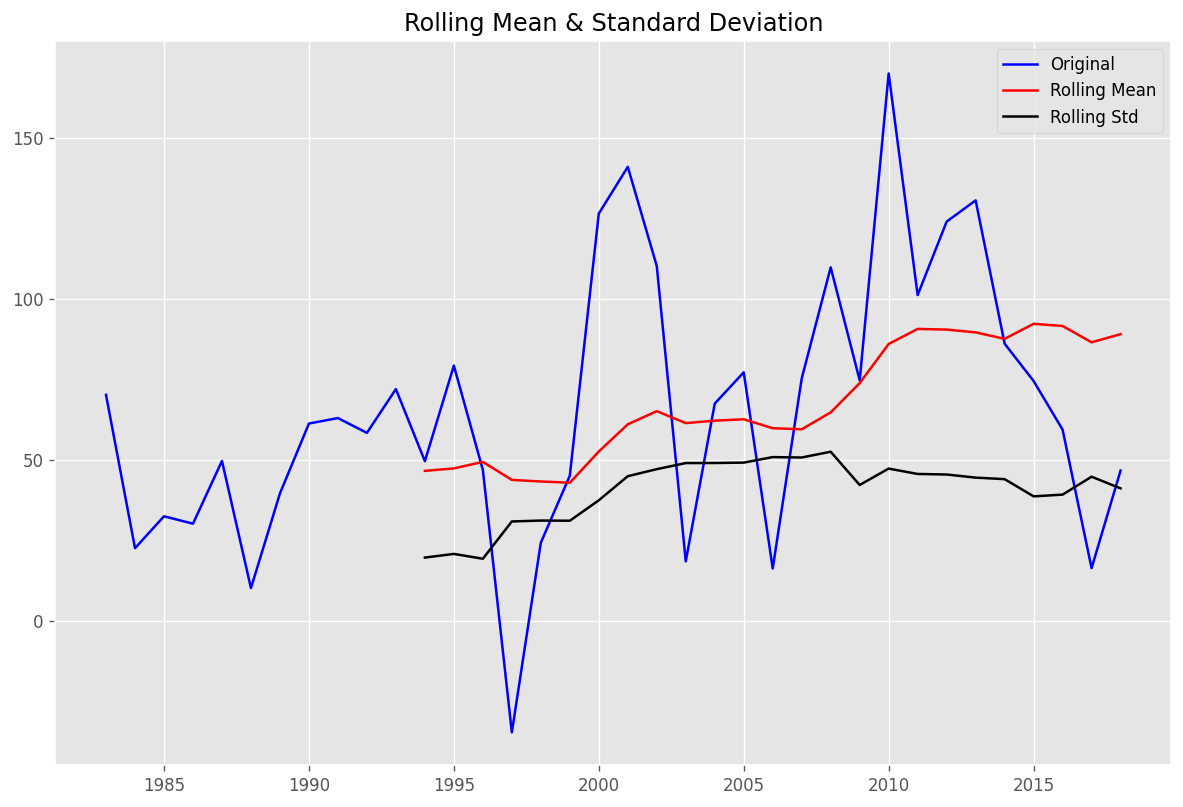

Results of Dickey-Fuller Test:
p-value = 0.0095. The series is likely stationary.
Test Statistic                 -3.444382
p-value                         0.009536
#Lags Used                      0.000000
Number of Observations Used    35.000000
Critical Value (1%)            -3.632743
Critical Value (5%)            -2.948510
Critical Value (10%)           -2.613017
dtype: float64


In [335]:
first_diff = df2.food_retailing - df2.food_retailing.shift(1)
first_diff = first_diff.dropna(inplace = False)
test_stationarity(first_diff, window = 12)

In [336]:
arima = sm.tsa.ARIMA(df2.food_retailing, (6,1,0)).fit(disp=False)
print(arima.summary())

                             ARIMA Model Results                              
Dep. Variable:       D.food_retailing   No. Observations:                   36
Model:                 ARIMA(6, 1, 0)   Log Likelihood                -179.688
Method:                       css-mle   S.D. of innovations             35.326
Date:                Thu, 18 Feb 2021   AIC                            375.376
Time:                        22:02:25   BIC                            388.044
Sample:                             1   HQIC                           379.797
                                                                              
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     65.5198     10.027      6.534      0.000      45.867      85.173
ar.L1.D.food_retailing     0.4589      0.165      2.780      0.009       0.135       0.783
ar.L

                             ARIMA Model Results                              
Dep. Variable:       D.food_retailing   No. Observations:                   36
Model:                 ARIMA(0, 1, 6)   Log Likelihood                -178.592
Method:                       css-mle   S.D. of innovations             33.740
Date:                Thu, 18 Feb 2021   AIC                            373.184
Time:                        22:02:28   BIC                            385.852
Sample:                             1   HQIC                           377.605
                                                                              
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     64.9825     10.523      6.175      0.000      44.358      85.607
ma.L1.D.food_retailing     0.5320      0.166      3.206      0.003       0.207       0.857
ma.L

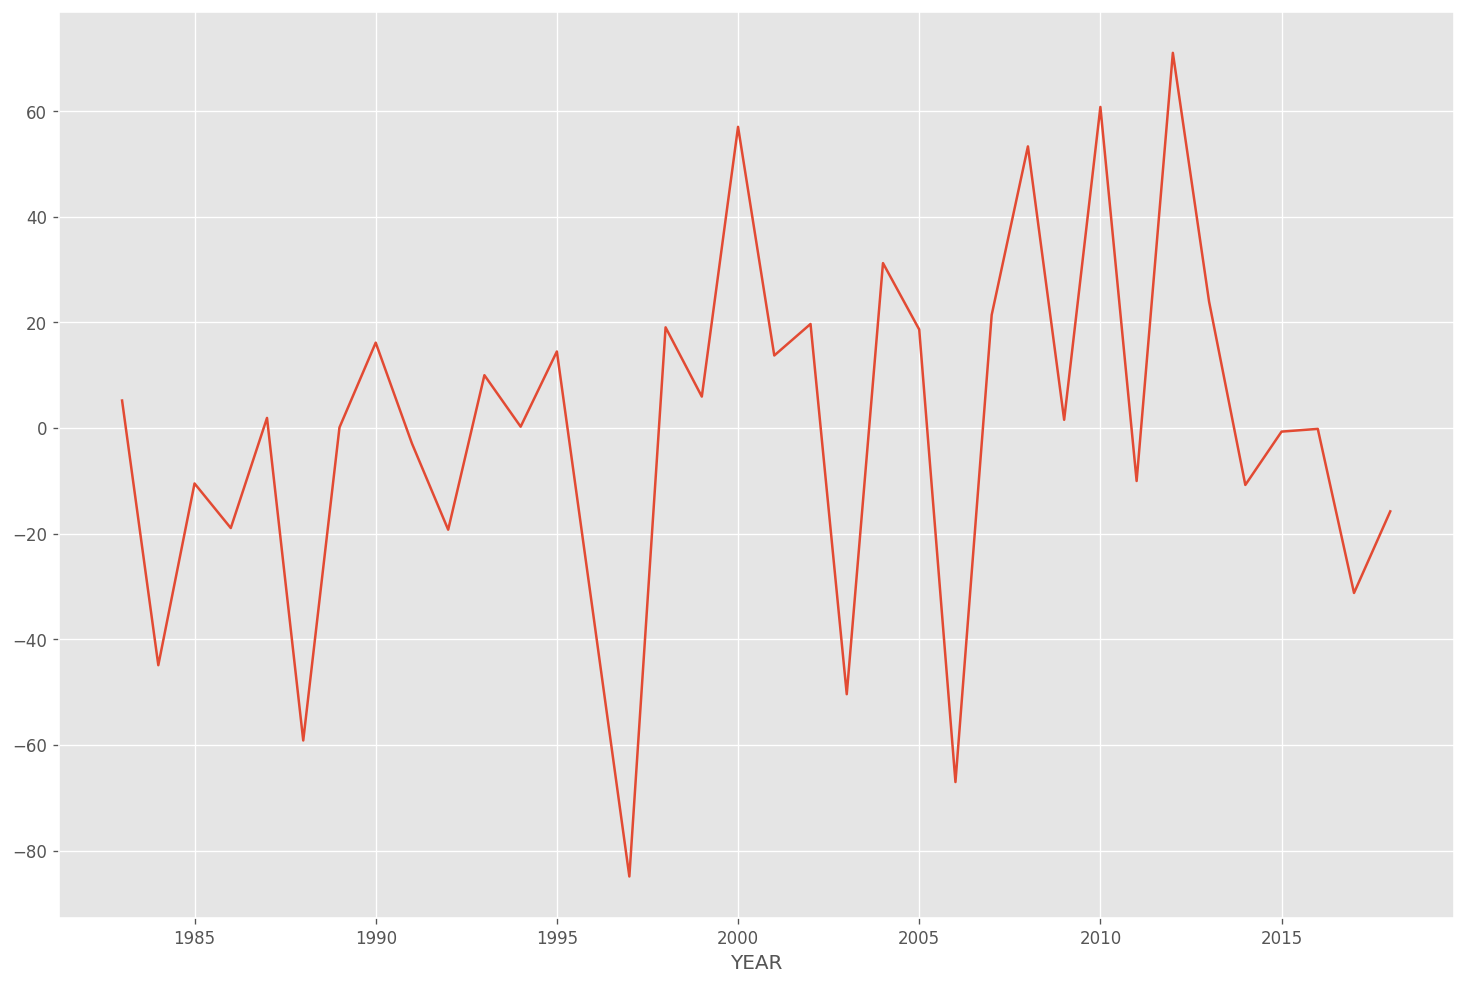

In [337]:
model=sm.tsa.ARIMA(endog=df2['food_retailing'],order=(0,1,6))
results=model.fit()
print(results.summary())
results.resid.plot()
plt.show()

## Task 3. Analyze the PACF and ACF plots to determine appropriate number of AR, MA terms

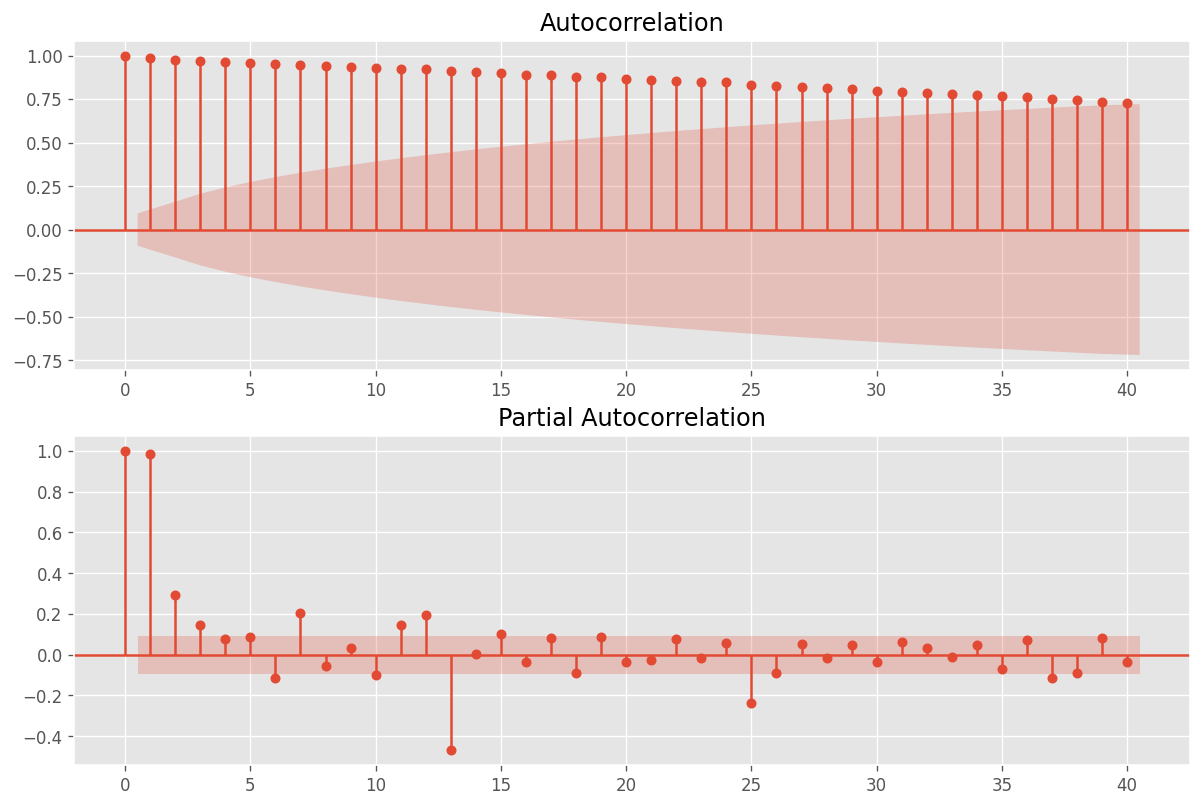

In [338]:
#data.columns
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.food_retailing, lags=40, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.food_retailing, lags=40, ax=ax2) 

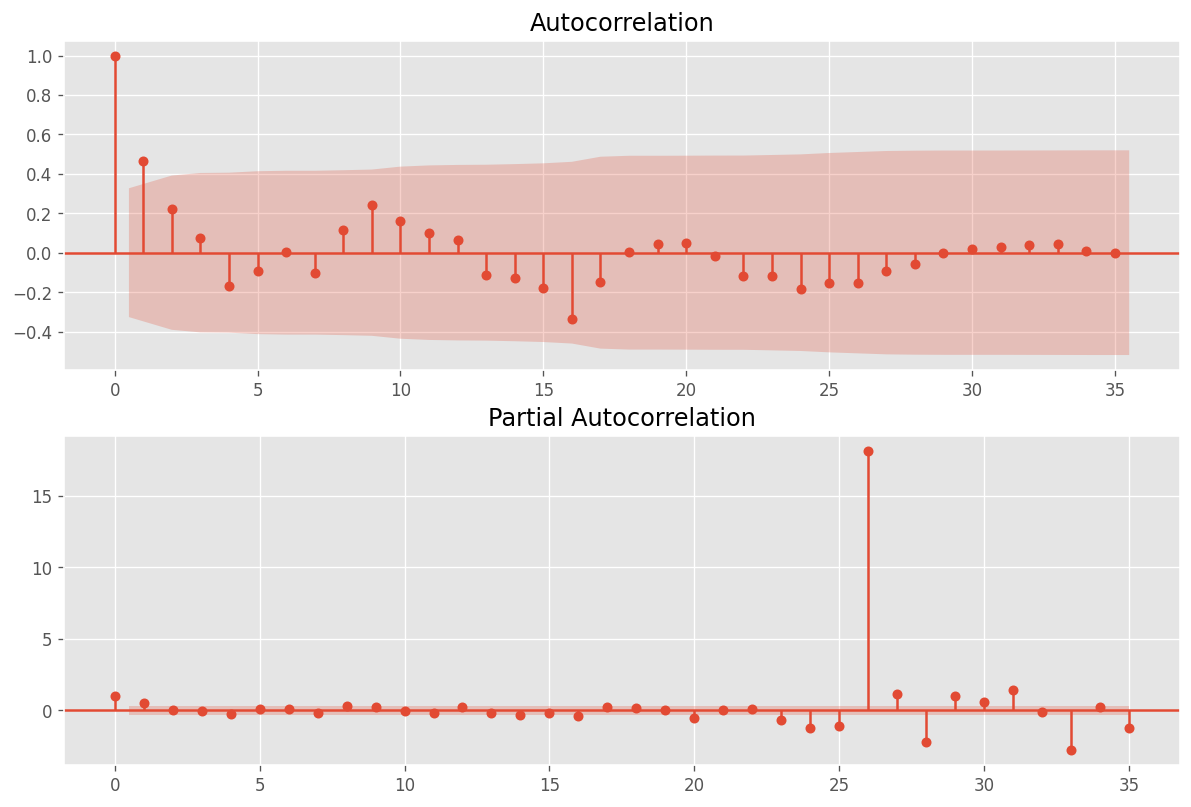

In [339]:
# Using different lags 
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, lags=35, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, lags=40, ax=ax2)


Because the autocorrelation of the differenced series shows a negative lag AR model might be investigated first with lag length selected from the PACF or via empirical investigation. 

## Determine appropriate number of AR, MA terms and Predictions

In [340]:
X = df['food_retailing'].dropna()
train_data = X[1:len(X)-12]
test_data = X[len(X)-12:]

In [341]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import r2_score

In [342]:
model = AR(train_data)
model_fitted = model.fit()
('The lag value chose is: %s' % model_fitted.k_ar)
#The lag value chosen for this model is 17.  

'The lag value chose is: 17'

In [343]:
# make predictions 
predictions = model_fitted.predict(
    start=len(train_data), 
    end=len(train_data) + len(test_data)-1,
    dynamic=False)
# create a comparison dataframe
compare_df = pd.concat(
    [df2['food_retailing'].reset_index().tail(12),
     predictions], axis=1).rename(
    columns={'food_retailing': 'actual', 0:'predicted'})
compare_df=compare_df[['actual', 'predicted']].dropna()

In [344]:
print (predictions)

428    204.741198
429    196.294842
430    211.162687
431    208.658054
432    210.633974
433    199.840603
434    204.999252
435    204.655175
436    203.696212
437    209.618112
438    213.601593
439    235.648986
dtype: float64


NormaltestResult(statistic=98.47281794192035, pvalue=4.1390366805692414e-22)


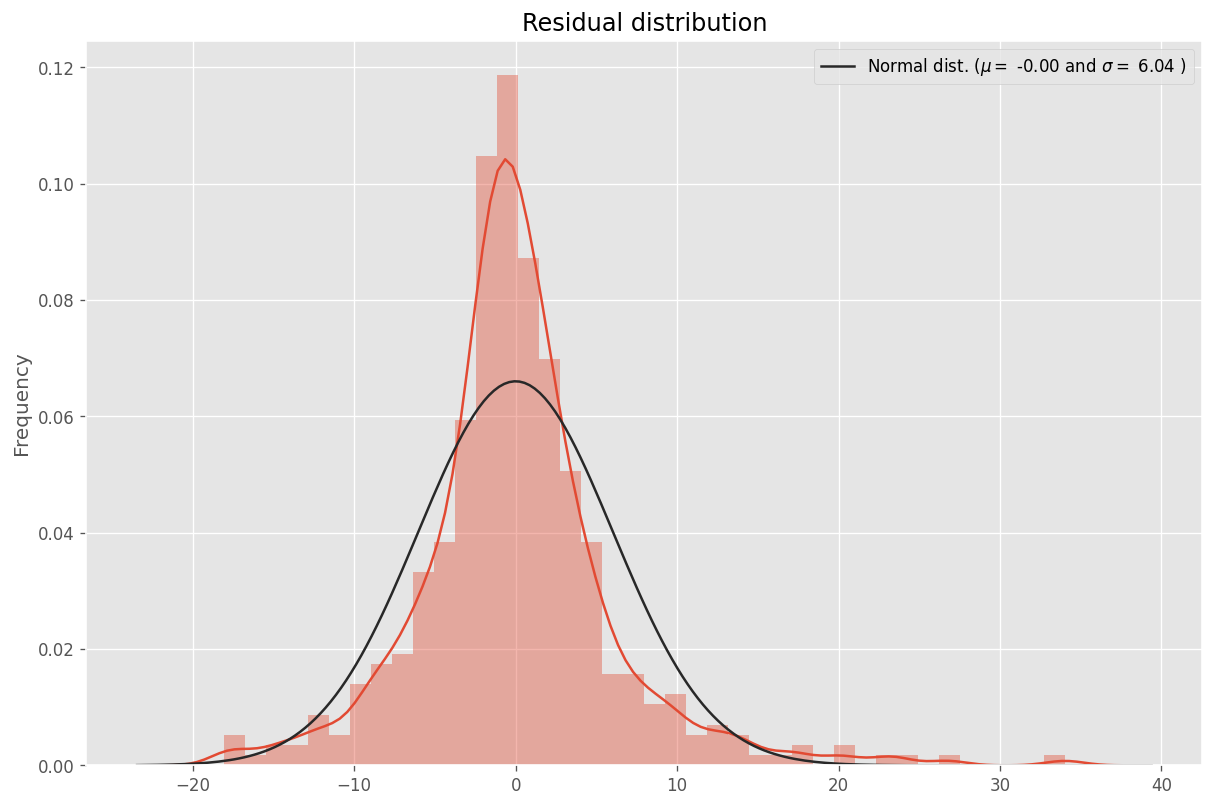

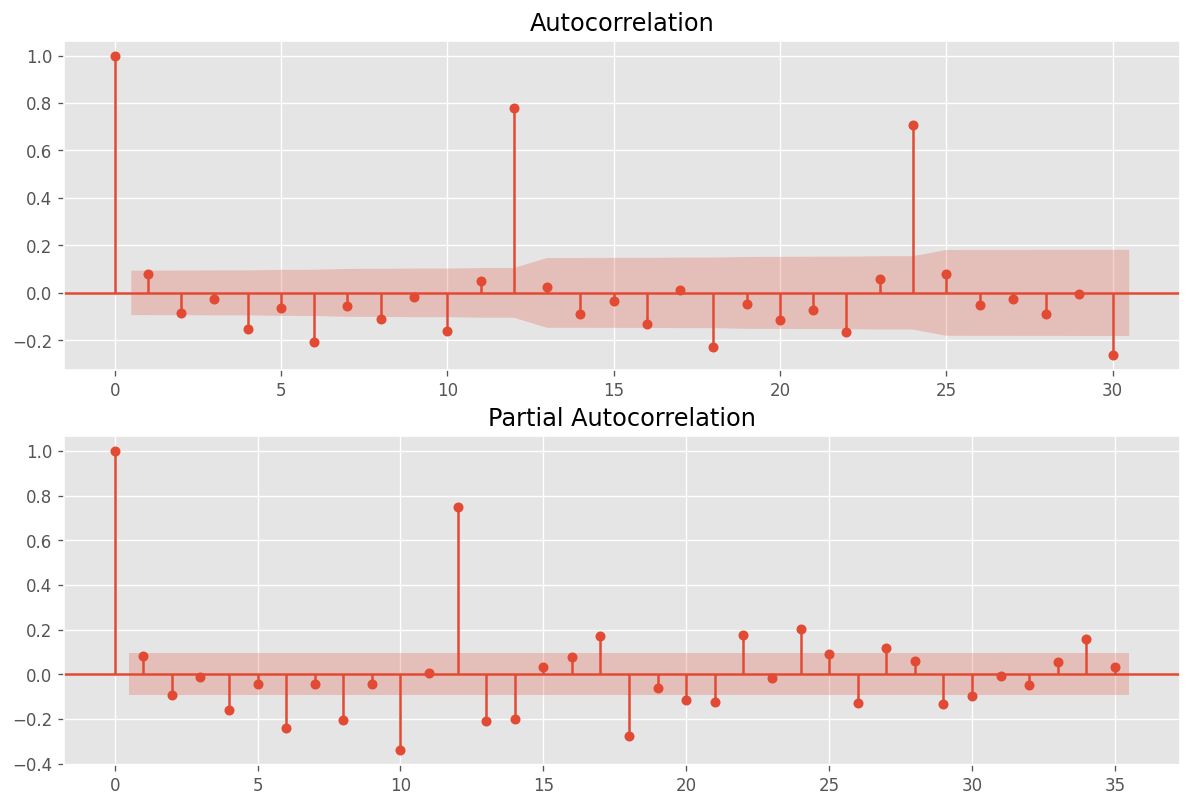

In [345]:
from scipy import stats
from scipy.stats import normaltest
import seaborn as sns
import statsmodels.api as sm

resid = fitted_arima_model.resid
print(normaltest(resid))
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(fitted_arima_model.resid, lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(fitted_arima_model.resid, lags=35, ax=ax2)

#### To be noted that although the graph looks very like a normal distribution. But it failed the test. Also we see a big differences in both of the exists in both ACF and PACF

In [346]:
print(normaltest(resid))

NormaltestResult(statistic=98.47281794192035, pvalue=4.1390366805692414e-22)


In [347]:
residual_normaltest_p_value= 4.1390366805692414e-22

In [348]:
adfuller_p_value= 0.9991

In [349]:
fitted_arima_model

In [350]:
### a function for grading
def outputResults(adfuller_p_value, fitted_arima_model, residual_normaltest_p_value):
    import csv
    '''
    please pass your argument in this function
    adfuller_p_value: the p value of the stationary series from adfuller test;
    fitted_arima_model: your fitted ARIMA model;
    residual_normaltest_p_value: the normal test's p value of residual from ARIMA model
    '''
    if type(adfuller_p_value) == np.ndarray:
        adfuller_p_value = adfuller_p_value[0]
    if type(residual_normaltest_p_value) == np.ndarray:
        residual_normaltest_p_value = residual_normaltest_p_value[0]
    with open('output.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        writer.writerow(['adfuller','AIC','normaltest'])
        writer.writerow([adfuller_p_value, fitted_arima_model.aic, residual_normaltest_p_value])

In [351]:
#print (outputResults(adfuller_p_value, fitted_arima_model, residual_normaltest_p_value))

# Task 4, build up an ARIMA(1,1,1) model, train on the first 30 data points, test on the last 7. Check the autocorrelation and normal distribution hypothesis for the residuals.

In [377]:
#from statsmodels.tsa.arima_model import ARIMA
model1=ARIMA(df['food_retailing'],order=(1,1,1))
fitted_arima_model=model1.fit()
fitted_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:       D.food_retailing   No. Observations:                  440
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1421.791
Method:                       css-mle   S.D. of innovations              6.118
Date:                Thu, 18 Feb 2021   AIC                           2851.582
Time:                        22:24:00   BIC                           2867.929
Sample:                             1   HQIC                          2858.031
                                                                              
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.4619      0.056      8.220      0.000       0.352       0.572
ar.L1.D.food_retailing     0.1629      0.058      2.791      0.005       0.049       0.277
ma.L1.D.food_retailing    -0.8407      0.028    -29.607      0.000      -0.896      -0.785
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            6.1395           +0.0000j            6.1395            0.0000
MA.1            1.1894           +0.0000j            1.1894            0.0000
-----------------------------------------------------------------------------
"""

In [380]:
# make predictions 
predictions1 = model_fitted.predict(
    start=len(train_data), 
    end=len(train_data) + len(test_data)-7,
    dynamic=False)
# create a comparison dataframe
compare_df2 = pd.concat(
    [df2['food_retailing'].reset_index().head(30),
     predictions], axis=1).rename(
    columns={'food_retailing': 'actual', 0:'predicted'})
compare_df2=compare_df2[['actual', 'predicted']].dropna()

In [381]:
predictions1

428    204.741198
429    196.294842
430    211.162687
431    208.658054
432    210.633974
433    199.840603
dtype: float64

train on the first 30 data points, test on the last 7. Check the autocorrelation and normal distribution hypothesis for the residuals.

NormaltestResult(statistic=140.98157184328537, pvalue=2.4335521039375763e-31)


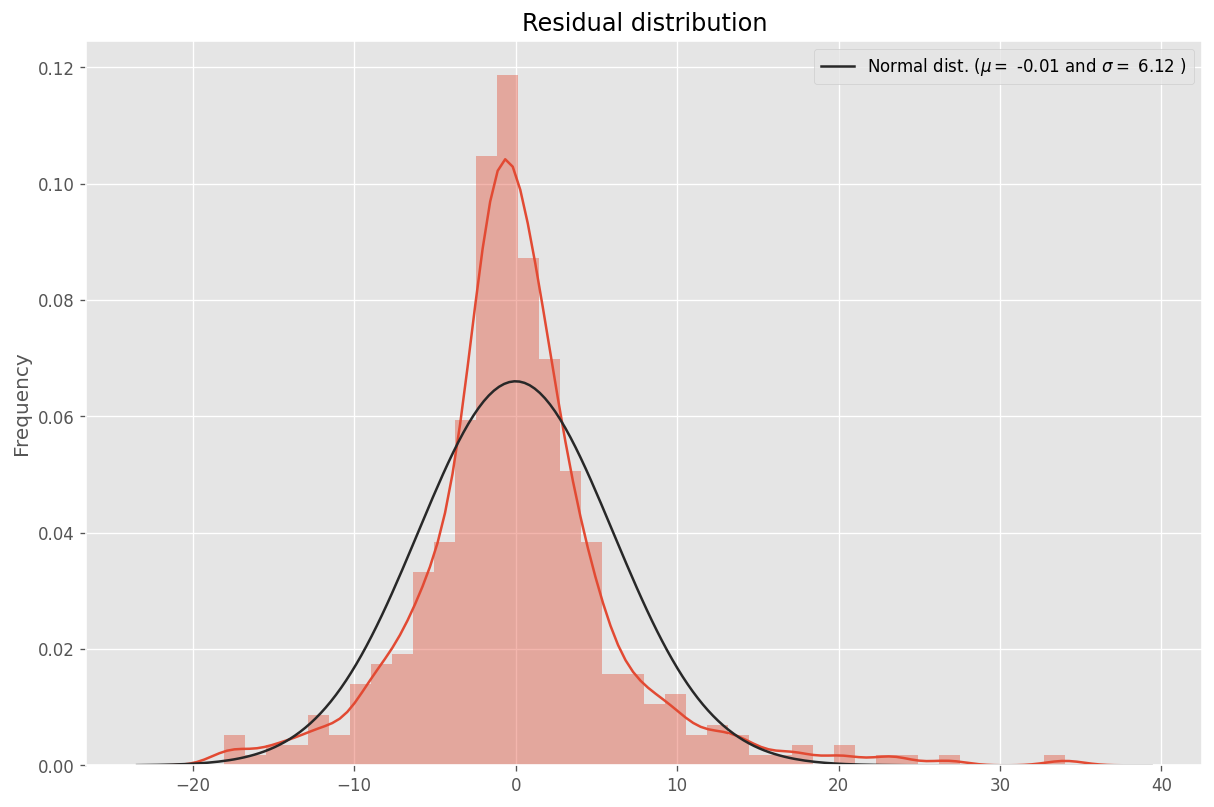

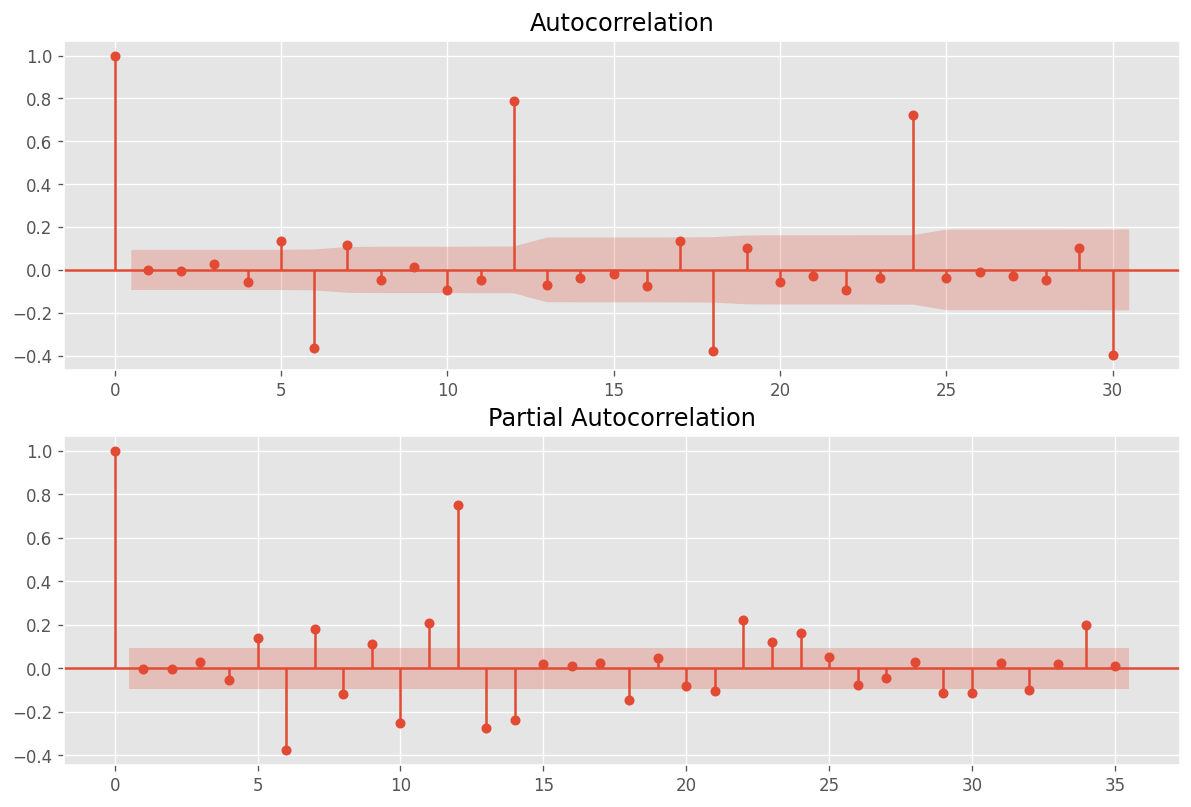

In [383]:
resid1 = fitted_arima_model.resid
print(normaltest(resid1))
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid1)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')
# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(fitted_arima_model.resid, lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(fitted_arima_model.resid, lags=35, ax=ax2)


# Homework 2: Using ARIMA model to predict a one-direction random walk.
## Task 1, generate a one-dimensional random walk which starts at 0 and makes a step up or down with the equal probability. Simulate 1000 steps and use the random seed 1234. Visualize the result.

Text(0.5, 0, 'Seconds')

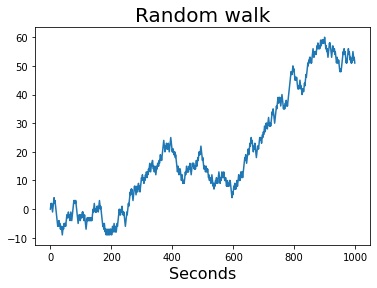

In [6]:
# Simple Application 1: A Random Walk.

# Set an arbitrary starting point and iterate the system using a simple Markov process.
# Each second, this process can move up 1 or it can move down, which it does at random.
# Pr(up) = Pr(down) = 0.5.

# pos is starting position.
# draws are random integers, {0, 1}.
# step is -1 if random draw is 0 and +1 if random draw is 1.
# walk is the vector containing each step.

np.random.seed(1234)

pos = 0  
walk = [pos] # walk is the array that tracks the random path
nsteps = 1000 # establishs number of random steps
for i in range(nsteps):
    step = 1 if np.random.randint(0, 2) else -1 # Bernoulli draw to step "up" or "down"
    pos += step
    walk.append(pos)

plt.plot(walk[0:1000])
plt.title('Random walk', fontsize=20)
plt.xlabel('Seconds', fontsize=16)

## Task 2, difference the series to stationary, and report the adfuller test results, $\alpha=0.05$

In [7]:
# statistical test
result = adfuller(walk)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.350132
p-value: 0.918098
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


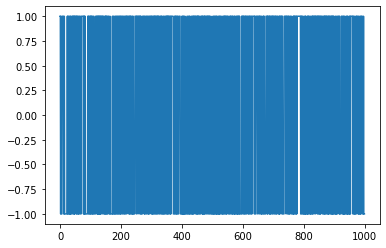

In [8]:
# take difference
diff = list()
for i in range(1, len(walk)):
    value = walk[i] - walk[i - 1]
    diff.append(value)
# line plot
plt.plot(diff)
plt.show()


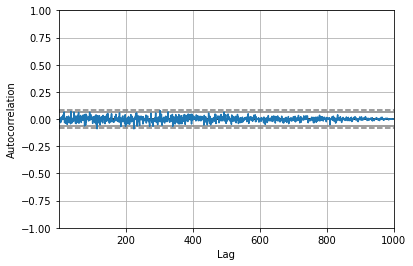

In [9]:
# take difference
from pandas.plotting import autocorrelation_plot
diff = list()
for i in range(1, len(walk)):
    value = walk[i] - walk[i - 1]
    diff.append(value)
# line plot
autocorrelation_plot(diff)
plt.show()

## Task 3, PACF and ACF plot of the diferenced time-series.

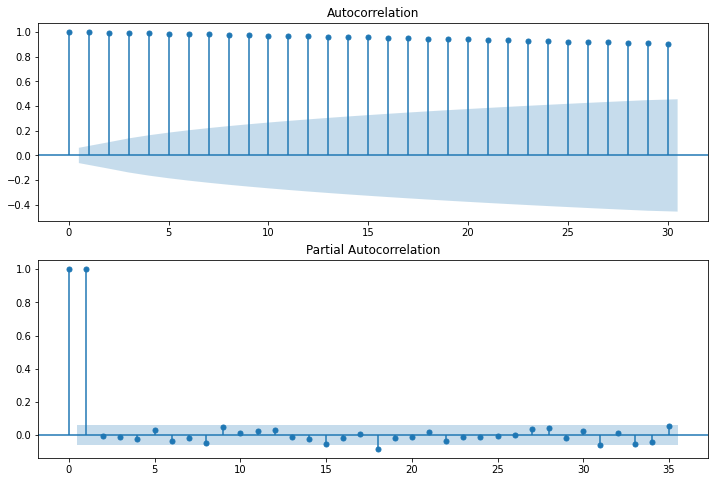

In [10]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(walk, lags=30, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(walk, lags=35, ax=ax2) 

## Task 4, When analyzing the PACF and ACF results of the random walk, what pattern shows that ARIMA won't be a useful model for this time-series? Write down your statement.

A random dataset does not hold trends because it uses a 50/50 probability, where it chooses a random number to go up and down. The random walk model assumes that the future trend will equal the average trend observed in the past or in this case given dataset. 